## Intro to using beautiful soup to scrape web football data

### Install Beautiful Soup

In [3]:
# pip install beautifulsoup4

     |████████████████████████████████| 97 kB 13.1 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## We will now want to import all the necessary packages require for scraping and analysis:

In [64]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
import matplotlib.patheffects as pe
from highlight_text import fig_text
from adjustText import adjust_text


In [65]:
def generate_squadlist(url):
    # name = [element.text for element in BeautifulSoup.find_all("span")]
    # name = name[7]    
    html = requests.get(url).text
    data = BeautifulSoup(html, 'html5')
    table = data.find('table')
    cols = []

    for header in table.find_all('th'):
        cols.append(header.string)

    columns = cols[8:37] #gets necessary column headers
    players = cols[37:-2]

    #display(columns)
    rows = [] #initliaze list to store all rows of data
    for rownum, row in enumerate(table.find_all('tr')): #find all rows in table
        if len(row.find_all('td')) > 0: 
            rowdata = [] #initiliaze list of row data
            for i in range(0,len(row.find_all('td'))): #get all column values for row
                rowdata.append(row.find_all('td')[i].text)
            rows.append(rowdata)
    df = pd.DataFrame(rows, columns=columns)

    df.drop(df.tail(2).index,inplace=True)
    df["Player"] = players
    df.drop('Matches', axis=1, inplace=True)
    df['Nation'] = df['Nation'].str[3:]
    # df["team"] = name
    df.set_index("Player")

    return df 

In [66]:
team = "https://fbref.com/en/squads/d48ad4ff/Napoli-Stats"
team_name = team[37:-6]
squad_stats_per_team = generate_squadlist(team)
squad_stats_per_team

,Nation,Pos,Age,MP,Starts,Min,90s,Gls,Ast,G-PK,...,xG,npxG,xA,npxG+xA,xG,xA,xG+xA,npxG,npxG+xA,Player
0,ITA,DF,28-223,29,29,"2,531",28.1,1,2,1,...,1.0,1.0,2.5,3.5,0.04,0.09,0.12,0.04,0.12,Giovanni Di Lorenzo
1,POR,DF,30-292,26,26,"2,304",25.6,0,3,0,...,1.3,1.3,2.6,4.0,0.05,0.10,0.15,0.05,0.15,Mário Rui
2,KVX,DF,28-019,26,26,"2,297",25.5,3,0,3,...,3.2,3.2,0.2,3.5,0.13,0.01,0.14,0.13,0.14,Amir Rrahmani
3,COL,GK,33-196,25,25,"2,250",25.0,0,0,0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,David Ospina
4,POL,MF,27-299,27,23,"1,742",19.4,5,5,5,...,2.8,2.8,2.9,5.7,0.14,0.15,0.30,0.14,0.30,Piotr Zieliński
5,ESP,MF,25-346,24,22,"1,881",20.9,6,2,6,...,1.2,1.2,2.5,3.8,0.06,0.12,0.18,0.06,0.18,Fabián Ruiz Peña
6,ITA,FW,30-284,23,20,"1,614",17.9,7,5,1,...,10.3,3.4,4.3,7.7,0.58,0.24,0.82,0.19,0.43,Lorenzo Insigne
7,SEN,DF,30-268,19,19,"1,685",18.7,2,1,2,...,1.5,1.5,0.1,1.7,0.08,0.01,0.09,0.08,0.09,Kalidou Koulibaly
8,ITA,FW,28-224,26,16,"1,361",15.1,1,3,1,...,2.2,2.2,3.7,5.9,0.15,0.25,0.39,0.15,0.39,Matteo Politano
9,NGA,FW,23-076,19,16,"1,354",15.0,9,0,9,...,8.2,8.2,0.9,9.1,0.55,0.06,0.61,0.55,0.61,Victor Osimhen


In [67]:
def years_converter(variable_value):
    years = variable_value[:-4]
    days = variable_value[3:]
    years_value = pd.to_numeric(years)
    days_value = pd.to_numeric(days)
    day_conv = days_value/365
    final_val = years_value + day_conv

    return final_val

In [68]:
squad_stats_per_team['age_new'] = squad_stats_per_team.apply(lambda x: years_converter(x['Age']), axis=1)

In [103]:
def squad_age_profile_chart(df, team_name):
        df[["90s"]] = df[["90s"]].apply(pd.to_numeric)        
        df["Min_pct"] = 100*df["90s"]/38 ##number of matches in a Serie A season
        df = df.dropna(subset=["Age", "Min_pct"])
        df = df.loc[:len(df)-1, :]
        df[["Player", "Pos", "age_new", "Min_pct"]].head()

        line_color = "silver"
        marker_color = "dodgerblue"
        fig, ax = plt.subplots(figsize=(12, 8)) 

        ax.scatter(df["age_new"], df["Min_pct"],alpha=0.8) ##scatter points
        ax.fill([24, 29, 29, 24], [-6, -6, 106, 106], color='limegreen',
                alpha=0.3, zorder=2) ##the peak age shaded region
        ax.text(26.5, 55, "PEAK", color=line_color, zorder=3, 
                alpha=2, fontsize=26, rotation=90, ha='center',
                va='center', fontweight='bold') ## `PEAK` age text
        texts = [] ##plot player names
        for row in df.itertuples():
                texts.append(ax.text(row.age_new, row.Min_pct, row.Player, fontsize=8, ha='center', va='center', zorder=10))
                adjust_text(texts) ## to remove overlaps between labels

        ## update plot
                ax.set(xlabel="Age", ylabel="Share of Minutes Played %", ylim=(-5, 105), xlim=(16, 40)) ## set labels and limits

        ##grids and spines
        ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
        for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)
                ax.spines[spine].set_color(line_color)
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.xaxis.set_ticks(range(16, 44, 4)) ##fix the tick frequency 
        ax.xaxis.label.set(fontsize=12, fontweight='bold')
        ax.yaxis.label.set(fontsize=12, fontweight='bold') ## increase the weight of the axis labels

        ax.set_position([0.08, 0.08, 0.82, 0.78]) ## make space for the title on top of the axes

        ## title and subtitle
        fig.text(x=0.08, y=0.92, s=f"{team_name} | Squad Age Profile", 
                ha='left', fontsize=20, fontweight='light', 
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()]) 
        fig.text(x=0.08, y=0.88, s=f"Serie A | 2020-21", ha='left', 
                fontsize=20, fontweight='light', 
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()])

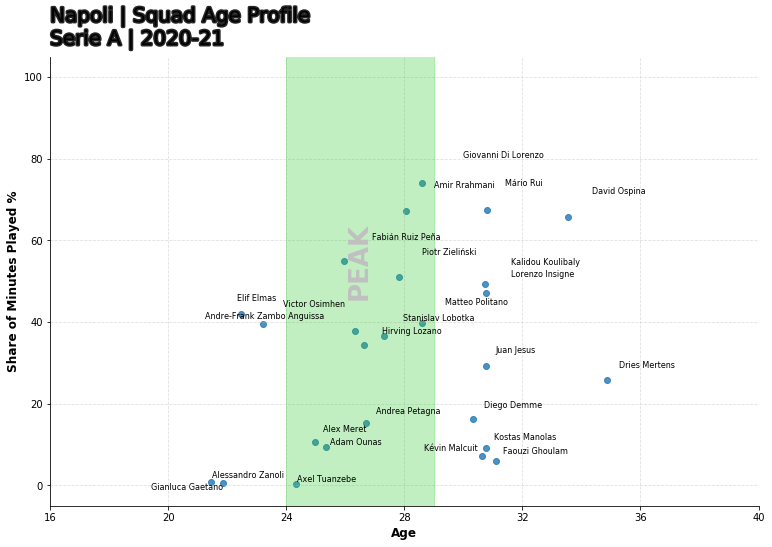

In [104]:
squad_age_profile_chart(squad_stats_per_team,team_name)

In [106]:
def team_fixture_data(x):
    url = x
    page = urlopen(url).read()
    soup = BeautifulSoup(page)
    count = 0 
    table = soup.find("tbody")

    pre_df = dict()
    features_wanted =  {"date" , "time","comp","Round","dayofweek", "venue","result","goals_for","goals_against","opponent","xg_for","xg_against","possession","attendance","captain", "formation","referee"} #add more features here!!
    rows = table.find_all('tr')
    for row in rows:
        for f in features_wanted:
            if (row.find('th', {"scope":"row"}) != None) & (row.find("td",{"data-stat": f}) != None):
                cell = row.find("td",{"data-stat": f})
                a = cell.text.strip().encode()
                text=a.decode("utf-8")
                if f in pre_df:
                    pre_df[f].append(text)
                else:
                    pre_df[f]=[text]
                
    df = pd.DataFrame.from_dict(pre_df)
    return df 
    

In [110]:
league_results = team_fixture_data("https://fbref.com/en/squads/d48ad4ff/2021-2022/matchlogs/all_comps/schedule/Napoli-Scores-and-Fixtures-All-Competitions")
league_results = league_results.loc[(league_results['captain'] != '') & (league_results['comp'] == 'Serie A')]
league_results 

,xg_for,dayofweek,formation,comp,result,xg_against,possession,referee,goals_for,captain,venue,attendance,goals_against,time,opponent
0,2.3,Sun,4-3-3,Serie A,W,0.5,56,Gianluca Aureliano,2,Lorenzo Insigne,Home,"20,000",0,20:45,Venezia
1,1.1,Sun,4-3-3,Serie A,W,0.6,61,Marco Di Bello,2,Lorenzo Insigne,Away,"20,000",1,18:30,Genoa
2,2.1,Sat,4-3-3,Serie A,W,1.0,67,Massimiliano Irrati,2,Lorenzo Insigne,Home,"23,500",1,18:00,Juventus
4,2.4,Mon,4-3-3,Serie A,W,0.3,63,Gianluca Manganiello,4,Lorenzo Insigne,Away,"11,484",0,20:45,Udinese
5,2.2,Thu,4-3-3,Serie A,W,0.6,52,Paolo Valeri,4,Lorenzo Insigne,Away,"4,596",0,18:30,Sampdoria
6,1.8,Sun,4-3-3,Serie A,W,0.2,67,Marco Piccinini,2,Lorenzo Insigne,Home,"20,000",0,20:45,Cagliari
8,1.7,Sun,4-2-3-1,Serie A,W,0.7,45,Simone Sozza,2,Lorenzo Insigne,Away,"15,264",1,18:00,Fiorentina
9,1.6,Sun,4-2-3-1,Serie A,W,0.9,51,Juan Sacchi,1,Lorenzo Insigne,Home,"27,579",0,18:00,Torino
11,0.9,Sun,4-2-3-1,Serie A,D,1.3,62,Davide Massa,0,Lorenzo Insigne,Away,"47,801",0,18:00,Roma
12,2.6,Thu,4-2-3-1,Serie A,W,0.2,65,Marco Serra,3,Lorenzo Insigne,Home,"20,000",0,20:45,Bologna


In [120]:
def generate_xg_analysis_chart(df):
        window = 5
        gd_color = "green"
        xgd_color = "blue"

        df[["goals_for","xg_for","xg_against","goals_against"]] = df[["goals_for","xg_for","xg_against","goals_against"]].apply(pd.to_numeric)

        df["GD"] = df["goals_for"] - df["goals_against"]
        df["xGD"] = df["xg_for"] - df["xg_against"]

        gd_rolling = df["GD"].rolling(window).mean().values[window:]
        xgd_rolling = df["xGD"].rolling(window).mean().values[window:]

        plt.rcParams['font.family'] = 'Palatino Linotype' ##set global font
        fig, ax = plt.subplots(figsize=(12, 8))

        ax.plot(gd_rolling, color=gd_color,  linestyle="-.", marker="o",  mfc=gd_color, mec="white", markersize=8, mew=0.4, zorder=10)  ##goal-difference
        ax.plot(xgd_rolling, color=xgd_color,  linestyle="-.", marker = "o", mfc=xgd_color, mec="white", markersize=8, mew=0.4, zorder=10) ##expected goals difference

        ax.fill_between(x=range(len(gd_rolling)), y1=gd_rolling, y2=xgd_rolling, where = gd_rolling>xgd_rolling, 
                        alpha=0.2, color=gd_color, interpolate=True, zorder=5) ##shade the areas in between
        ax.fill_between(x=range(len(gd_rolling)), y1=gd_rolling, y2=xgd_rolling, where = gd_rolling<=xgd_rolling, 
                        alpha=0.2, color=xgd_color, interpolate=True, zorder=5)

        ax.grid(linestyle="dashed", lw=0.7, alpha=0.1, zorder=1) ## a faint grid
        for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)  
        ax.set_position([0.08, 0.08, 0.82, 0.78]) ## make space for the title on top of the axes

        ## labels, titles and subtitles
        ax.set(xlabel=f"{window} match rolling mean", xlim=(-1, len(df)-window))     
        ax.xaxis.label.set(fontsize=12, fontweight='bold')    

        fig.text(x=0.08, y=0.92, s=f"{team_name} | Performance Trend", 
                ha='left', fontsize=24, fontweight='bold', 
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()])   

        fig_text(x=0.08, y=0.90, ha='left',
                fontsize=18, fontweight='bold',
                s='Ligue 1 | 2020-21 | <Goal Difference> vs <Expected Goal Difference>',
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()],
                highlight_textprops=[{"color": gd_color},
                                        {"color": xgd_color}])
        
#     fig.savefig("xg-trend-line-chart", dpi=180) ##save image

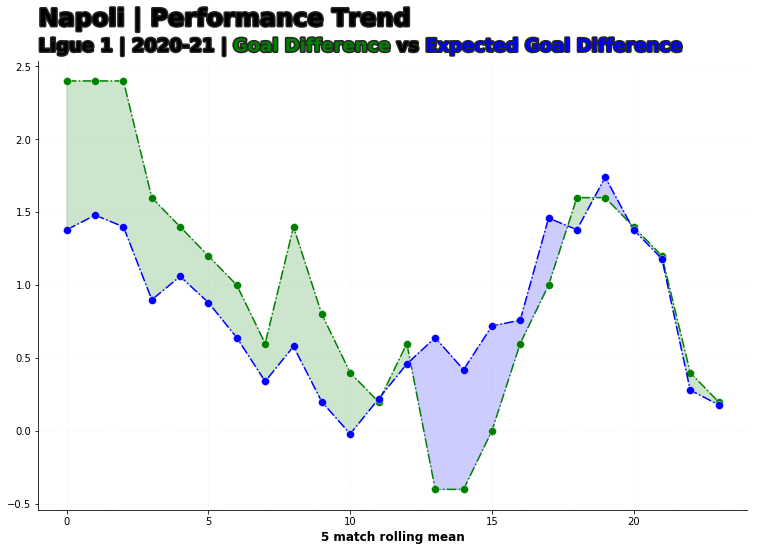

In [121]:
generate_xg_analysis_chart(league_results)

In [124]:
def generate_league_data(x):
    url = x
    page = urlopen(url).read()
    soup = BeautifulSoup(page)
    count = 0 
    table = soup.find("tbody")

    pre_df = dict()
    features_wanted =  {"squad" , "games","wins","draws","losses", "goals_for","goals_against", "points", "xg_for","xg_against","xg_diff","attendance","xg_diff_per90", "last_5"} #add more features here!!
    rows = table.find_all('tr')
    for row in rows:
        for f in features_wanted:
            if (row.find('th', {"scope":"row"}) != None) & (row.find("td",{"data-stat": f}) != None):
                cell = row.find("td",{"data-stat": f})
                a = cell.text.strip().encode()
                text=a.decode("utf-8")
                if f in pre_df:
                    pre_df[f].append(text)
                else:
                    pre_df[f]=[text]
                
    df = pd.DataFrame.from_dict(pre_df)
    df["games"] = pd.to_numeric(df["games"])
    df["xg_diff_per90"] = pd.to_numeric(df["xg_diff_per90"])
    df["minutes_played"] = df["games"] *90
    return(df)

In [125]:
generate_league_data("https://fbref.com/en/comps/11/Serie-A-Stats")

,xg_for,goals_against,games,points,xg_diff,draws,xg_against,last_5,goals_for,xg_diff_per90,wins,squad,losses,minutes_played
0,45.5,29,29,63,+17.0,6,28.4,W D D W W,55,0.59,19,Milan,4,2610
1,45.8,21,29,60,+24.1,6,21.7,D D W L W,51,0.83,18,Napoli,5,2610
2,59.1,23,28,59,+29.4,8,29.7,D L D W D,61,1.05,17,Inter,3,2520
3,38.8,26,29,56,+10.9,8,27.9,D D W W W,45,0.38,16,Juventus,5,2610
4,42.1,42,29,49,+6.5,7,35.6,W D L W W,58,0.22,14,Lazio,8,2610
5,50.0,35,29,48,+19.1,6,31.0,D D W W D,47,0.66,14,Roma,9,2610
6,46.2,31,28,48,+15.8,9,30.4,D L W L D,50,0.56,13,Atalanta,6,2520
7,44.6,37,28,46,+10.0,4,34.6,W W L D W,47,0.36,14,Fiorentina,10,2520
8,39.7,46,29,41,+4.5,8,35.2,W D W D L,54,0.16,11,Hellas Verona,10,2610
9,43.5,48,29,40,-6.5,10,50.0,D W W W D,51,-0.22,10,Sassuolo,9,2610


In [126]:
df = generate_league_data("https://fbref.com/en/comps/9/Premier-League-Stats")
df['path'] = df["squad"] + '.png'
df[["squad","xg_for","xg_against", "path"]]

,squad,xg_for,xg_against,path
0,Manchester City,67.0,21.2,Manchester City.png
1,Liverpool,71.2,27.1,Liverpool.png
2,Chelsea,46.7,24.8,Chelsea.png
3,Arsenal,41.2,33.0,Arsenal.png
4,Manchester Utd,44.8,41.3,Manchester Utd.png
5,West Ham,40.0,36.2,West Ham.png
6,Wolves,27.9,40.5,Wolves.png
7,Tottenham,43.7,31.4,Tottenham.png
8,Aston Villa,32.2,35.2,Aston Villa.png
9,Southampton,39.3,41.4,Southampton.png


In [127]:
def p90_Calculator(variable_value, minutes_played):
    
    variable_value = pd.to_numeric(variable_value)
    
    ninety_minute_periods = minutes_played/90
    
    p90_value = variable_value/ninety_minute_periods
    
    return p90_value

def form_ppg_calc(variable_value):
    wins = variable_value.count("W")
    draws = variable_value.count("D")
    losses = variable_value.count("L")
    points = (wins*3) + (draws)
    ppg = points/5
    return ppg

def getImage(path):
    return OffsetImage(plt.imread(path), zoom=.05, alpha = 1)

In [128]:
df['xG_p90'] = df.apply(lambda x: p90_Calculator(x['xg_for'], x['minutes_played']), axis=1)
df['xGA_p90'] = df.apply(lambda x: p90_Calculator(x['xg_against'], x['minutes_played']), axis=1)
df['ppg_form'] = df.apply(lambda x: form_ppg_calc(x['last_5']), axis=1)

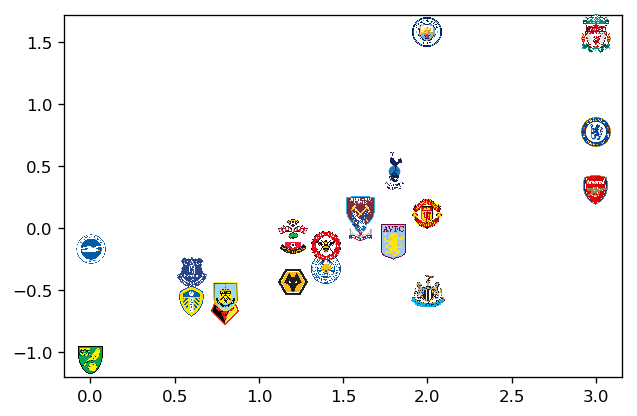

In [129]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
ax.scatter(df["ppg_form"], df["xg_diff_per90"])

for index, row in df.iterrows():
    ab = AnnotationBbox(getImage(os.path.join("team_logos/"+row["path"])), (row["ppg_form"], row["xg_diff_per90"]), frameon=False)
    ax.add_artist(ab)

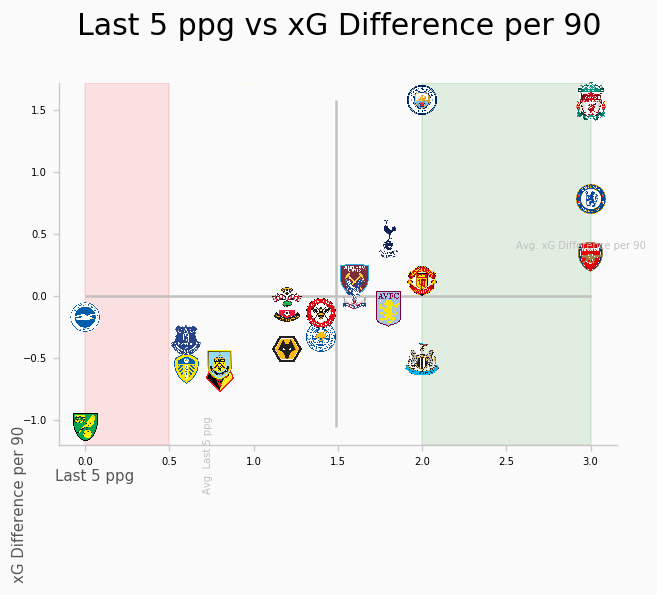

In [137]:
# Set font and background colour
bgcol = '#fafafa'

# Create initial plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
fig.set_facecolor(bgcol)
ax.set_facecolor(bgcol)
ax.scatter(df['ppg_form'], df['xg_diff_per90'], c=bgcol)

# Change plot spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#ccc8c8')
ax.spines['bottom'].set_color('#ccc8c8')

# Change ticks
plt.tick_params(axis='x', labelsize=6, color='#ccc8c8')
plt.tick_params(axis='y', labelsize=6, color='#ccc8c8')

# Plot badges
def getImage(path):
    return OffsetImage(plt.imread(path), zoom=.05, alpha = 1)

for index, row in df.iterrows():
    ab = AnnotationBbox(getImage(os.path.join("team_logos/"+row["path"])), (row['ppg_form'], row['xg_diff_per90']), frameon=False)
    ax.add_artist(ab)

# Add average lines
plt.hlines(df['xg_diff_per90'].mean(), df['ppg_form'].min(), df['ppg_form'].max(), color='#c2c1c0')
plt.vlines(df['ppg_form'].mean(), df['xg_diff_per90'].min(), df['xg_diff_per90'].max(), color='#c2c1c0')
ax.axvspan(2.0, 3,0, alpha=0.1, color='green',label= "In Form")
ax.axvspan(0.9, 1,2, alpha=0.1, color='yellow',label= "Mediorcre")
ax.axvspan(0.0, 0.5, alpha=0.1, color='red',label= "relegation on speed dail")

# Text

## Title & comment
fig.text(.15,.98,'Last 5 ppg vs xG Difference per 90',size=18)

## Avg line explanation
fig.text(.06,.14,'xG Difference per 90', size=9, color='#575654',rotation=90)
fig.text(.12,0.05,'Last 5 ppg', size=9, color='#575654')

## Axes titles
fig.text(.76,.535,'Avg. xG Difference per 90', size=6, color='#c2c1c0')
fig.text(.325,.17,'Avg. Last 5 ppg', size=6, color='#c2c1c0',rotation=90)

## Save plot
plt.savefig('xGChart.png', dpi=1200, bbox_inches = "tight")